## Model 2: CNN-LSTM (With Dimensionality Reduction)
Architecture
Input: PCA-reduced features, reshaped for sequence

Layers: Conv1D → LSTM → Dense

### The CNN-LSTM Hybrid Architecture: Structure, Function, and Benefits
    Recent advances in machine learning for financial time series forecasting and portfolio optimization have highlighted the efficacy of hybrid architectures, particularly the combination of Convolutional Neural Networks (CNNs) and Long Short-Term Memory networks (LSTMs). The CNN-LSTM model leverages the strengths of both architectures to capture complex temporal and spatial dependencies in financial data.

#### Architecture Overview
    A CNN-LSTM hybrid model typically consists of one or more convolutional layers followed by LSTM layers. In this structure, the CNN layers act as local feature extractors, identifying short-term patterns and motifs within sliding windows of the input time series. The output of the CNN layers is then passed to the LSTM layers, which are designed to capture longer-term dependencies and sequential dynamics over time.

    "The CNN-LSTM model first applies convolutional layers to extract local temporal features from the input sequence, which are then fed into LSTM layers to model the sequential dependencies. This hybrid approach is particularly effective for financial time-series data, where both short-term fluctuations and long-term trends are relevant for prediction and decision-making."
        (Masuda, 2024, p. 41)

#### Functions and Mechanisms
    CNN Component:
        The convolutional layers scan over the input features and time steps, detecting local patterns such as sudden price jumps, reversals, or volatility clusters. This is analogous to how CNNs detect edges and textures in image data but applied to sequential financial signals.

    LSTM Component:
        The LSTM layers process the sequence of extracted features, learning how these local patterns evolve and interact over longer horizons. LSTM's gating mechanisms enable the model to retain or forget information as needed, which is crucial for modeling the non-stationary and noisy nature of financial markets.

#### Benefits of the CNN-LSTM Hybrid
    - Enhanced Predictive Power:
        By combining local pattern recognition (CNN) with sequence modeling (LSTM), the hybrid model can capture both micro and macro structures in financial data, leading to improved forecasting accuracy.

    - Robustness to Noise:
        The architecture is more robust to the high noise and volatility typical of financial time series, as the CNN can filter out irrelevant fluctuations before the LSTM processes the sequence.

    - Superior Portfolio Performance:
        Empirical studies have shown that CNN-LSTM hybrids outperform standalone CNNs, LSTMs, and traditional models in both prediction accuracy and downstream portfolio metrics such as the Sharpe ratio and mean return.

"The results demonstrate that the hybrid models perform better than the individual models, and the CNN-LSTM model outperforms benchmark market indices."
(Masuda, 2024, p. 61)   

    - Versatility:
        The model can be adapted for various financial prediction tasks, including price forecasting, volatility prediction, and asset selection for portfolio optimization

In [64]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import psutil
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 1. Data Loading and Preparation ---
data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
features = ['returns','RSI_14','Volatility_21','MACD','Beta','Alpha','Volume','DMI_minus_14','DMI_plus_14',
            'Calmar_Ratio_21','ATR_14','Open','Close','High','nonfarm_payrolls','real_gdp','cpi','treasury_10y','building_permits']

# Pivot to wide dataframe, one column per asset-feature
df_wide = pd.DataFrame()
for feat in features:
    temp = data.pivot(index='Date', columns='Ticker', values=feat)
    temp.columns = [f"{col}_{feat}" for col in temp.columns]
    if df_wide.empty:
        df_wide = temp
    else:
        df_wide = pd.concat([df_wide, temp], axis=1)
df_wide = df_wide.dropna()

returns_cols = [f"{asset}_returns" for asset in assets]
etf_returns = df_wide[returns_cols]

# Prepare feature matrix excluding returns
feature_cols = []
for asset in assets:
    for feat in features:
        if feat != 'returns':
            col_name = f"{asset}_{feat}"
            if col_name in df_wide.columns:
                feature_cols.append(col_name)
features_data = df_wide[feature_cols]

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_data)

# Apply PCA (tune n_components as needed, e.g., 50)
pca_components = 7
pca = PCA(n_components=pca_components)
features_pca = pca.fit_transform(features_scaled)
print(f"PCA applied: reduced features from {features_scaled.shape[1]} to {pca_components}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- 3. Generate improved dynamic portfolio weights incorporating risk ---
def risk_parity_weights(returns_window):
    cov = np.cov(returns_window.T)
    vol = np.sqrt(np.diag(cov))
    inv_vol = 1.0 / (vol + 1e-8)
    weights = inv_vol / inv_vol.sum()
    return weights

def generate_dynamic_weights_with_risk(returns_df, window=window_size):
    weights_list = []
    for i in range(len(returns_df) - 2*window):
        train_w = returns_df.iloc[i:i+window].values
        test_w = returns_df.iloc[i+window:i+2*window]
        mean_returns = test_w.mean()
        mean_returns[mean_returns < 0] = 0
        r_weights = risk_parity_weights(train_w)
        combined = mean_returns * r_weights
        combined[combined < 0] = 0
        if combined.sum() == 0:
            weights = np.ones(len(mean_returns)) / len(mean_returns)
        else:
            weights = combined / combined.sum()
        weights_list.append(weights)
    return np.array(weights_list)

window_size = 30
dynamic_weights = generate_dynamic_weights_with_risk(etf_returns, window=window_size)

# --- 3. Prepare sequences as [timesteps, features] for each window ---
def create_sequences(features_data, returns_data, weights_data, window):
    X, y_sharpe, y_weights = [], [], []
    for i in range(len(features_data) - window * 2):
        seq_x = features_data[i:i+window]
        returns_window = returns_data.iloc[i+window:i+window*2]
        mean_return = returns_window.mean().mean()
        std_return = returns_window.std().mean()
        sharpe = mean_return / (std_return + 1e-6)
        if i+window < len(weights_data):
            weight_target = weights_data[i+window]
        else:
            weight_target = np.ones(len(assets)) / len(assets)
        X.append(seq_x)
        y_sharpe.append(sharpe)
        y_weights.append(weight_target)
    return np.array(X), np.array(y_sharpe), np.array(y_weights)

X, y_sharpe, y_weights = create_sequences(features_pca, etf_returns, dynamic_weights, window_size)

# --- 4. Dataset and DataLoader ---
class PortfolioDataset(Dataset):
    def __init__(self, X, y_sharpe, y_weights):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_sharpe = torch.tensor(y_sharpe, dtype=torch.float32).unsqueeze(1)
        self.y_weights = torch.tensor(y_weights, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y_sharpe[idx], self.y_weights[idx]

X_train, X_test, y_sharpe_train, y_sharpe_test, y_weights_train, y_weights_test = train_test_split(
    X, y_sharpe, y_weights, test_size=0.2, random_state=42)

train_dataset = PortfolioDataset(X_train, y_sharpe_train, y_weights_train)
test_dataset = PortfolioDataset(X_test, y_sharpe_test, y_weights_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# --- 5. CNN→MaxPooling→Flatten→LSTM→Dense→Output Model ---
class CNNLSTMPortfolioModel(nn.Module):
    def __init__(self, num_features, n_assets, window):
        super(CNNLSTMPortfolioModel, self).__init__()
        self.cnn = nn.Conv1d(num_features, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=32, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, 64)
        self.sharpe_out = nn.Linear(64, 1)
        self.weights_out = nn.Linear(64, n_assets)
        self.softmax = nn.Softmax(dim=1)
        self.drop = nn.Dropout(0.3)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.permute(0, 2, 1)
        lstm_out, (h_n, _) = self.lstm(x)
        x = h_n[-1]
        x = self.drop(x)
        x = self.relu(self.fc1(x))
        sharpe = self.sharpe_out(x)
        weights = self.softmax(self.weights_out(x))
        return sharpe, weights

model = CNNLSTMPortfolioModel(num_features=pca_components, n_assets=len(assets), window=window_size).to(device)

# --- 6. Training Setup ---
criterion_sharpe = nn.MSELoss()
criterion_weights = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- 7. Training Loop ---
epochs = 50
model.train()
start_train = time.time()
cpu_start = psutil.cpu_percent(interval=None)

for epoch in range(epochs):
    epoch_loss = 0
    for batch_x, batch_sharpe, batch_weights in train_loader:
        batch_x = batch_x.to(device)
        batch_sharpe = batch_sharpe.to(device)
        batch_weights = batch_weights.to(device)
        optimizer.zero_grad()
        pred_sharpe, pred_weights = model(batch_x)
        loss_sharpe = criterion_sharpe(pred_sharpe, batch_sharpe)
        loss_weights = criterion_weights(pred_weights, batch_weights)
        loss = loss_sharpe + loss_weights
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.6f}")

train_time = time.time() - start_train
cpu_end = psutil.cpu_percent(interval=None)
cpu_usage = cpu_end - cpu_start

# --- 8. Evaluation ---
model.eval()
all_pred_sharpe = []
all_pred_weights = []
all_true_sharpe = []
all_true_weights = []
with torch.no_grad():
    for batch_x, batch_sharpe, batch_weights in test_loader:
        batch_x = batch_x.to(device)
        pred_sharpe, pred_weights = model(batch_x)
        all_pred_sharpe.append(pred_sharpe.cpu().numpy())
        all_pred_weights.append(pred_weights.cpu().numpy())
        all_true_sharpe.append(batch_sharpe.cpu().numpy())
        all_true_weights.append(batch_weights.cpu().numpy())

pred_sharpe = np.vstack(all_pred_sharpe).flatten()
pred_weights = np.vstack(all_pred_weights)
pred_weights /= pred_weights.sum(axis=1, keepdims=True)
true_sharpe = np.vstack(all_true_sharpe).flatten()
true_weights = np.vstack(all_true_weights)

test_returns = etf_returns.iloc[-len(pred_weights):].values
portfolio_returns = np.sum(test_returns * pred_weights, axis=1)
turnover = np.mean(np.sum(np.abs(np.diff(pred_weights, axis=0)), axis=1))

# --- 9. Metrics ---
def sortino_ratio(returns, risk_free=0, periods_per_year=252):
    returns = pd.Series(returns)
    downside_returns = returns[returns < risk_free]
    expected_return = returns.mean() * periods_per_year
    downside_std = downside_returns.std() * np.sqrt(periods_per_year)
    return expected_return / downside_std if downside_std != 0 else np.nan

def calmar_ratio(returns, freq='daily'):
    returns = pd.Series(returns)
    if freq == 'daily':
        periods_per_year = 252
    elif freq == 'monthly':
        periods_per_year = 12
    else:
        periods_per_year = 1
    cumulative = (1 + returns).cumprod()
    annualized_return = cumulative.iloc[-1] ** (periods_per_year / len(returns)) - 1
    max_drawdown = ((cumulative.cummax() - cumulative) / cumulative.cummax()).max()
    return annualized_return / max_drawdown if max_drawdown != 0 else np.nan

mse_sharpe = mean_squared_error(true_sharpe, pred_sharpe)
mae_sharpe = mean_absolute_error(true_sharpe, pred_sharpe)
r2_sharpe = r2_score(true_sharpe, pred_sharpe)
sortino = sortino_ratio(portfolio_returns)
calmar = calmar_ratio(portfolio_returns)

def evaluate_portfolio_performance(portfolio_returns, freq='daily'):
    portfolio_returns = pd.Series(portfolio_returns).replace([np.inf, -np.inf], np.nan).dropna()
    if len(portfolio_returns) == 0:
        raise ValueError("No valid portfolio returns to evaluate.")
    periods_per_year = 252 if freq == 'daily' else 12 if freq == 'monthly' else 1
    portfolio_values = (1 + portfolio_returns).cumprod()
    peak = portfolio_values.cummax()
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = drawdown.max()
    total_periods = len(portfolio_returns)
    annualized_return = (portfolio_values.iloc[-1]) ** (periods_per_year / total_periods) - 1
    annualized_volatility = portfolio_returns.std() * np.sqrt(periods_per_year)
    mean_return = portfolio_returns.mean() * periods_per_year
    sharpe_ratio = mean_return / annualized_volatility if annualized_volatility != 0 else np.nan
    return {
        'Sharpe Ratio': sharpe_ratio,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Maximum Drawdown': max_drawdown
    }

performance_metrics = evaluate_portfolio_performance(portfolio_returns, freq='daily')

print("\nComprehensive Performance Metrics Report")
print("========================================")
print(f"Training time (s): {train_time:.2f}")
print(f"CPU usage change (%): {cpu_usage:.2f}\n")
for metric, value in performance_metrics.items():
    if metric in ['Annualized Return', 'Annualized Volatility', 'Maximum Drawdown']:
        print(f"- {metric}: {value * 100:.2f}%")
    else:
        print(f"- {metric}: {value:.4f}")
print(f"- Sortino Ratio: {sortino:.4f}")
print(f"- Calmar Ratio: {calmar:.4f}")
print(f"- Average Turnover: {turnover:.4f}")
print(f"- Sharpe Ratio MSE: {mse_sharpe:.6f}")
print(f"- Sharpe Ratio MAE: {mae_sharpe:.6f}")
print(f"- Sharpe Ratio R^2: {r2_sharpe:.4f}")

weights_df = pd.DataFrame(pred_weights, index=etf_returns.index[-len(pred_weights):], columns=assets)
weights_df.to_csv('CNN_LSTM_PCA_weights.csv')
print("Saved CNN-LSTM hybrid portfolio weights.")


PCA applied: reduced features from 144 to 7
Epoch 1/50, Loss: 0.034709
Epoch 2/50, Loss: 0.030282
Epoch 3/50, Loss: 0.027644
Epoch 4/50, Loss: 0.025041
Epoch 5/50, Loss: 0.022524
Epoch 6/50, Loss: 0.020940
Epoch 7/50, Loss: 0.018818
Epoch 8/50, Loss: 0.016906
Epoch 9/50, Loss: 0.015742
Epoch 10/50, Loss: 0.014105
Epoch 11/50, Loss: 0.013234
Epoch 12/50, Loss: 0.012970
Epoch 13/50, Loss: 0.012211
Epoch 14/50, Loss: 0.011446
Epoch 15/50, Loss: 0.011088
Epoch 16/50, Loss: 0.010513
Epoch 17/50, Loss: 0.010219
Epoch 18/50, Loss: 0.009870
Epoch 19/50, Loss: 0.009724
Epoch 20/50, Loss: 0.009554
Epoch 21/50, Loss: 0.009126
Epoch 22/50, Loss: 0.009228
Epoch 23/50, Loss: 0.008919
Epoch 24/50, Loss: 0.008686
Epoch 25/50, Loss: 0.008477
Epoch 26/50, Loss: 0.008244
Epoch 27/50, Loss: 0.008556
Epoch 28/50, Loss: 0.008023
Epoch 29/50, Loss: 0.008174
Epoch 30/50, Loss: 0.007865
Epoch 31/50, Loss: 0.007776
Epoch 32/50, Loss: 0.007705
Epoch 33/50, Loss: 0.007449
Epoch 34/50, Loss: 0.007411
Epoch 35/50, 

#### Graphviz Architecture Visualization

In [61]:
from graphviz import Digraph

dot = Digraph(format='png')
dot.attr(rankdir='TB', size='4,14', dpi='300', bgcolor='white')

# Colors
lightblue = '#b3d8ff'
blue = '#3399ff'
green = '#4caf50'

# Nodes

dot.node('A', '''Input Layer
[batch, window, features]
(e.g., processed technical, macro features)''',
         shape='box', style='rounded,filled', fillcolor=lightblue, fontsize='14')

dot.node('B', '''Standardization
Zero mean, unit variance''',
         shape='box', style='rounded,filled', fillcolor=lightblue, fontsize='14')

dot.node('C', '''PCA Transformation
Dimensionality Reduction
Output: [batch, window, PCA components]''',
         shape='box', style='rounded,filled', fillcolor=lightblue, fontsize='14')

dot.node('D', '''CNN Layer
Conv1d, filters=32, kernel=3
Output: [batch, 32, window]''',
         shape='box', style='rounded,filled', fillcolor=blue, fontcolor='white', fontsize='14')

dot.node('E', '''MaxPooling
kernel=2
Output: [batch, 32, window//2]''',
         shape='box', style='rounded,filled', fillcolor=lightblue, fontsize='14')

dot.node('F', '''LSTM Layer
hidden=64, 1-layer
Output: (batch, 64) (last hidden state)''',
         shape='box', style='rounded,filled', fillcolor=blue, fontcolor='white', fontsize='14')

dot.node('G', '''Fully Connected Layer
Linear: [batch, 64] → [batch, 8 assets]''',
         shape='box', style='rounded,filled', fillcolor=blue, fontcolor='white', fontsize='14')

dot.node('H', '''Softmax (with Temperature)
Portfolio Weights Output
[batch, 8 assets] (sum=1)''',
         shape='box', style='rounded,filled', fillcolor=green, fontcolor='white', fontsize='14')


# Edges
dot.edge('A', 'B', color=blue, penwidth='2')
dot.edge('B', 'C', color=blue, penwidth='2')
dot.edge('C', 'D', color=blue, penwidth='2')
dot.edge('D', 'E', color=blue, penwidth='2')
dot.edge('E', 'F', color=blue, penwidth='2')
dot.edge('F', 'G', color=blue, penwidth='2')
dot.edge('G', 'H', color=green, penwidth='2')

# Title
dot.attr(label='CNN-LSTM Portfolio Model Architecture with PCA', labelloc='t', fontsize='20')

dot.render('cnn_lstm_pca_architecture', view=True)


'cnn_lstm_pca_architecture.png'

#### PyTorch Model Layer Summary

In [62]:
from torchinfo import summary
import torch
import torch.nn as nn

class CNNLSTMPortfolioModel(nn.Module):
    def __init__(self, num_features, n_assets, window):
        super(CNNLSTMPortfolioModel, self).__init__()
        self.cnn = nn.Conv1d(num_features, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=32, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, 64)
        self.sharpe_out = nn.Linear(64, 1)
        self.weights_out = nn.Linear(64, n_assets)
        self.softmax = nn.Softmax(dim=1)
        self.drop = nn.Dropout(0.3)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # batch, features, seq_len
        x = self.cnn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.permute(0, 2, 1)  # batch, seq_len//2, channels
        lstm_out, (h_n, _) = self.lstm(x)
        x = h_n[-1]
        x = self.drop(x)
        x = self.relu(self.fc1(x))
        sharpe = self.sharpe_out(x)
        weights = self.softmax(self.weights_out(x))
        return sharpe, weights

# Example configuration
pca_components = 7  # number of PCA components you used
n_assets = 8
window_size = 30
batch_size = 32

model = CNNLSTMPortfolioModel(num_features=pca_components, n_assets=n_assets, window=window_size)

# Assuming CPU, modify if CUDA available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Display model summary with example input tensor
summary(model, input_size=(batch_size, window_size, pca_components))


Layer (type:depth-idx)                   Output Shape              Param #
CNNLSTMPortfolioModel                    [32, 1]                   --
├─Conv1d: 1-1                            [32, 32, 30]              704
├─ReLU: 1-2                              [32, 32, 30]              --
├─MaxPool1d: 1-3                         [32, 32, 15]              --
├─LSTM: 1-4                              [32, 15, 64]              25,088
├─Dropout: 1-5                           [32, 64]                  --
├─Linear: 1-6                            [32, 64]                  4,160
├─ReLU: 1-7                              [32, 64]                  --
├─Linear: 1-8                            [32, 1]                   65
├─Linear: 1-9                            [32, 8]                   520
├─Softmax: 1-10                          [32, 8]                   --
Total params: 30,537
Trainable params: 30,537
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 12.87
Input size (MB): 0.03
Forward/backw

#### Visualizations

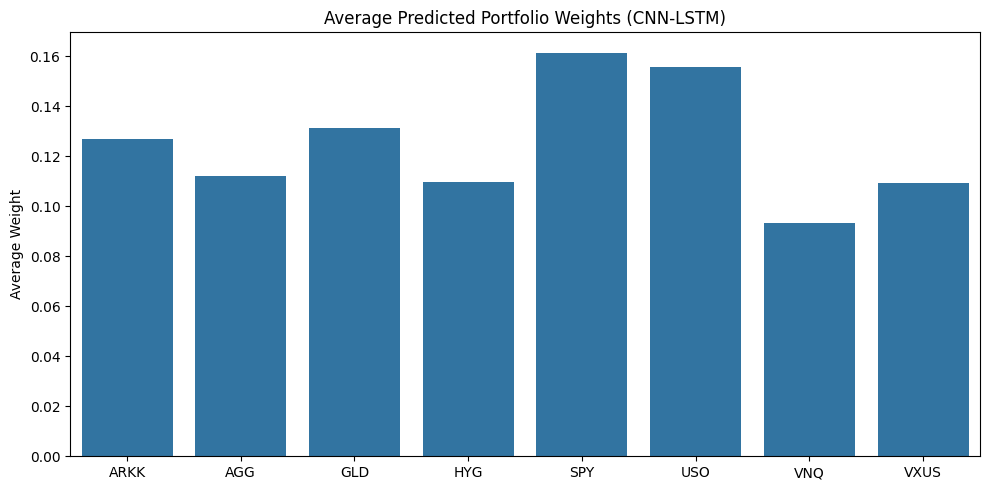

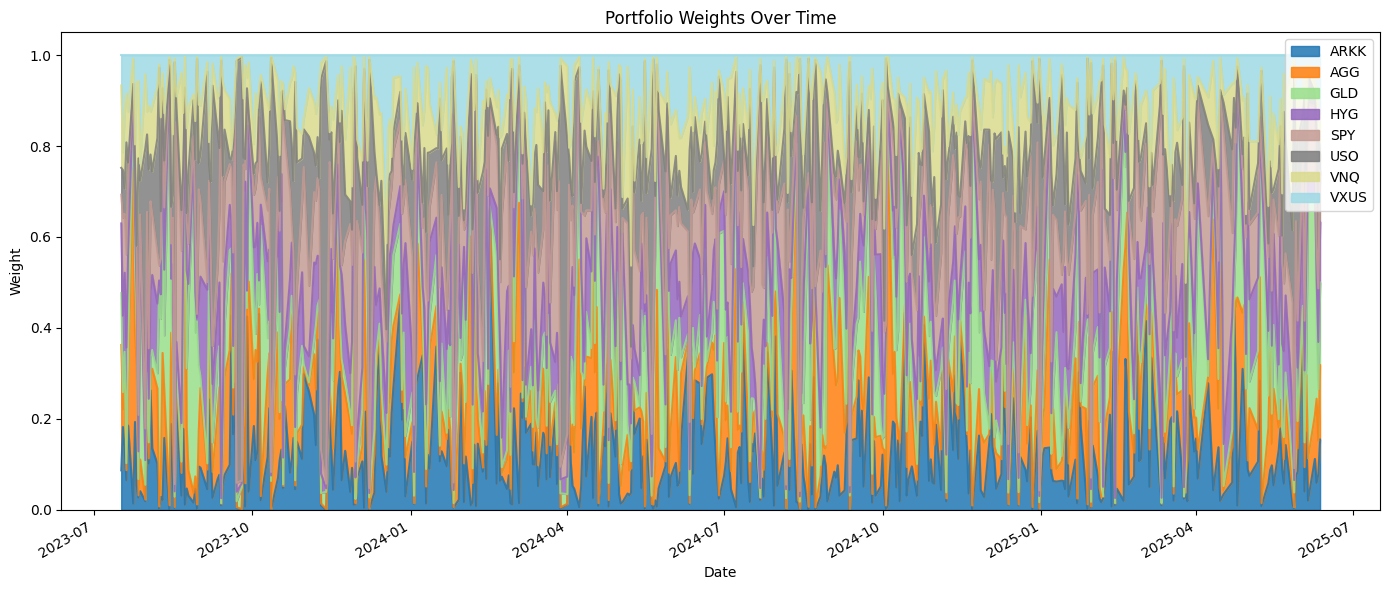

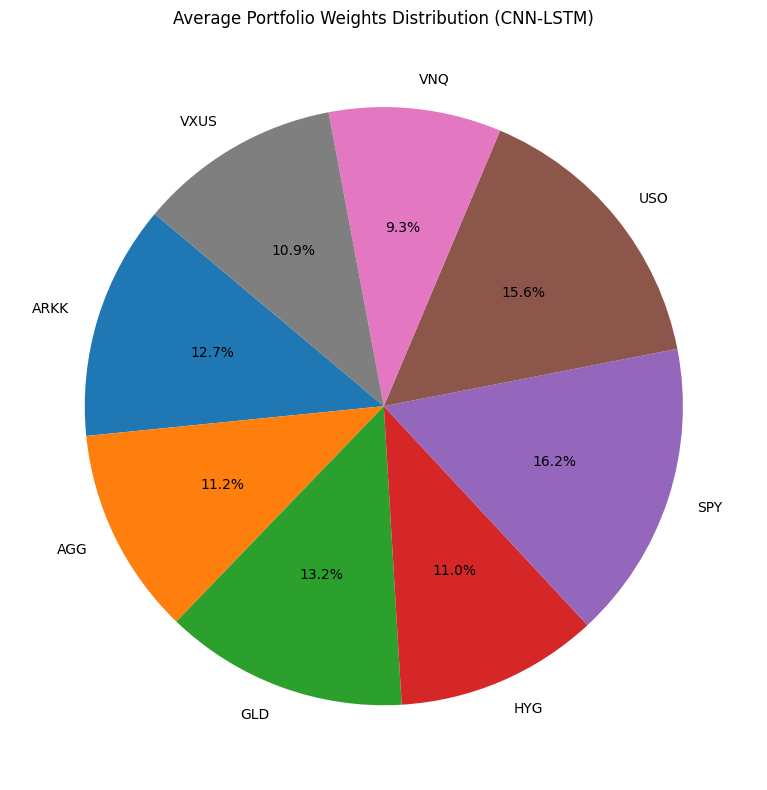

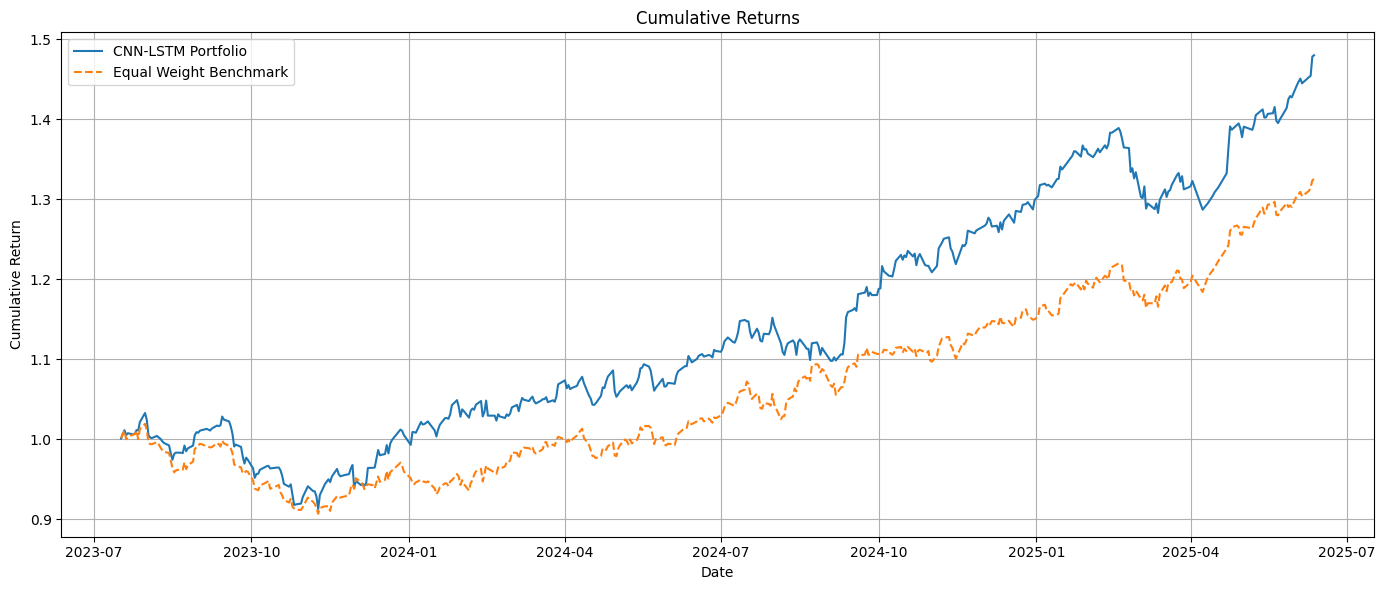

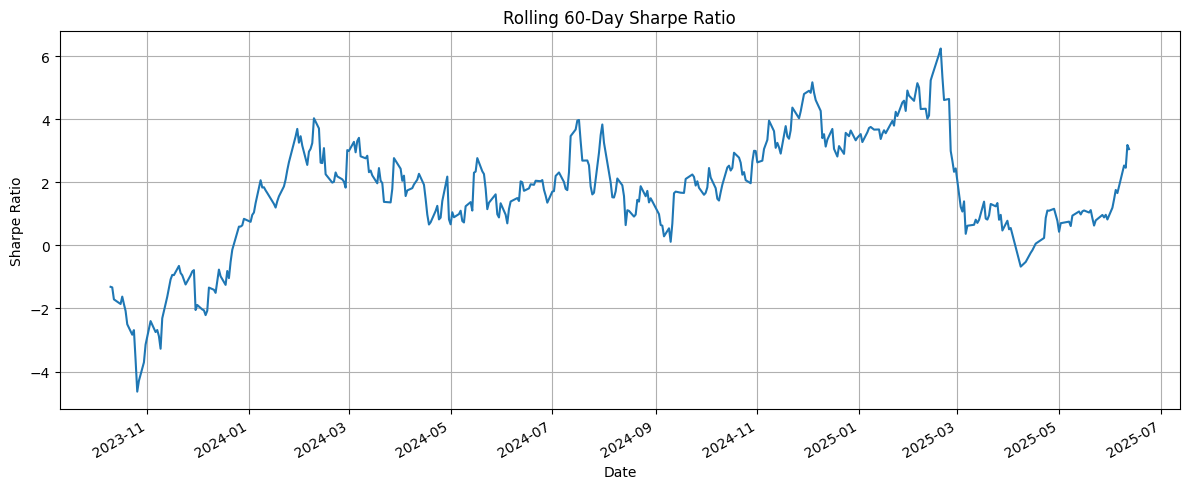

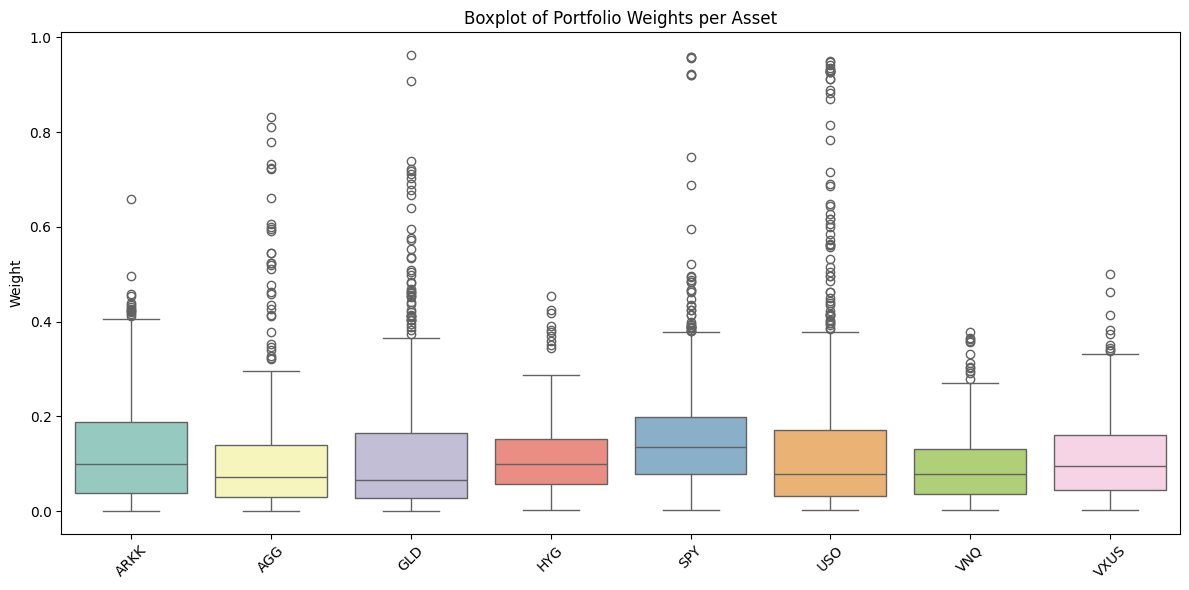

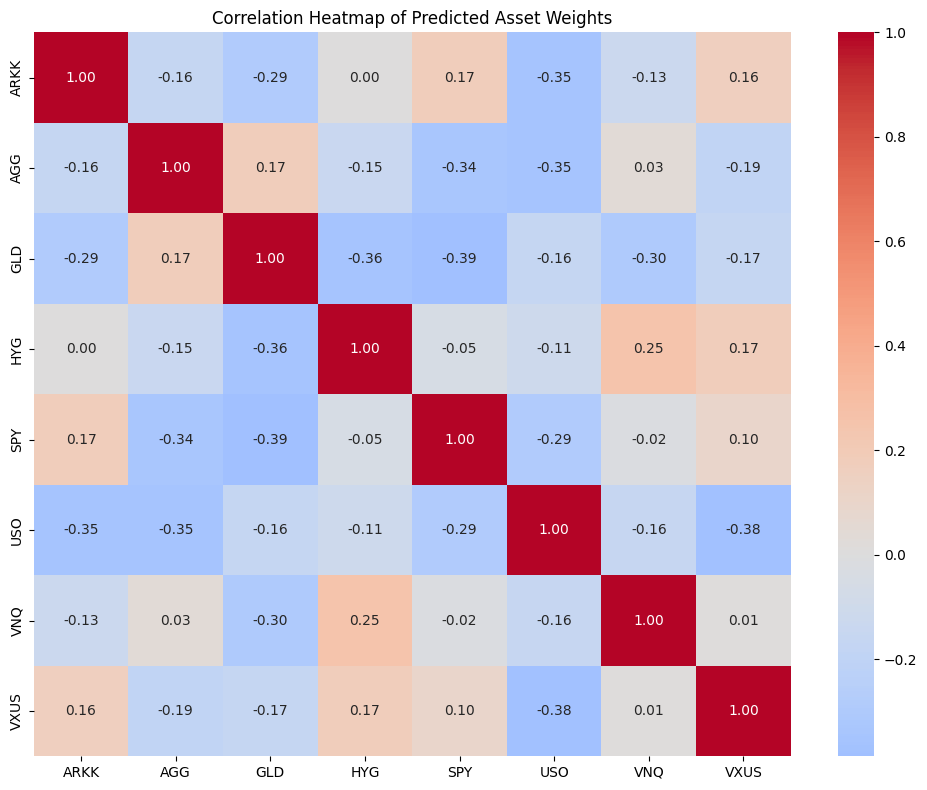

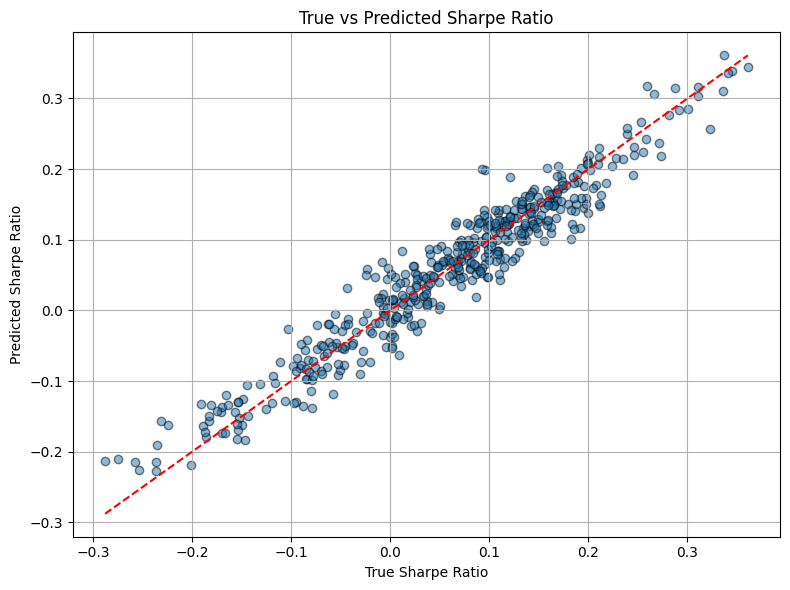

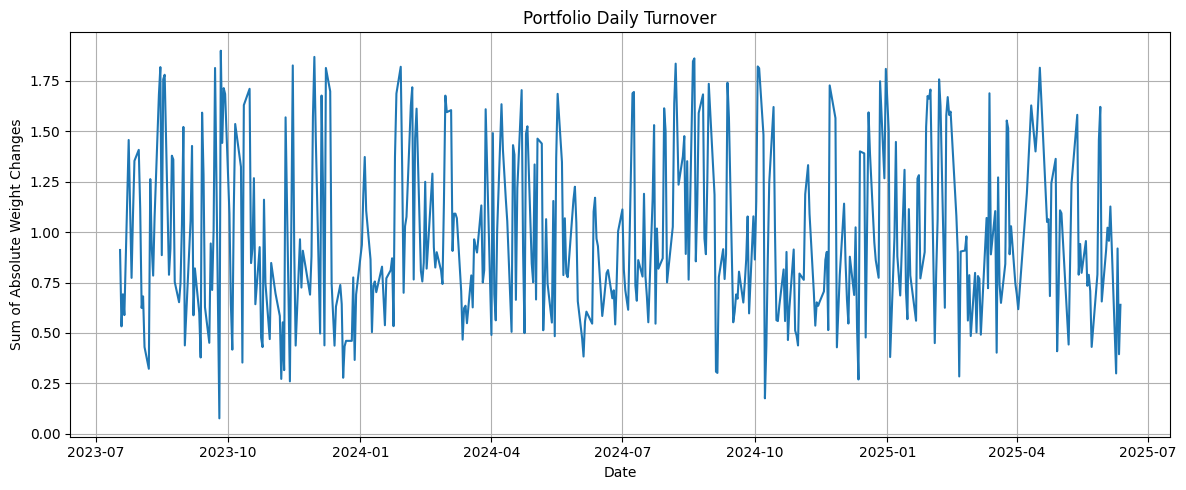

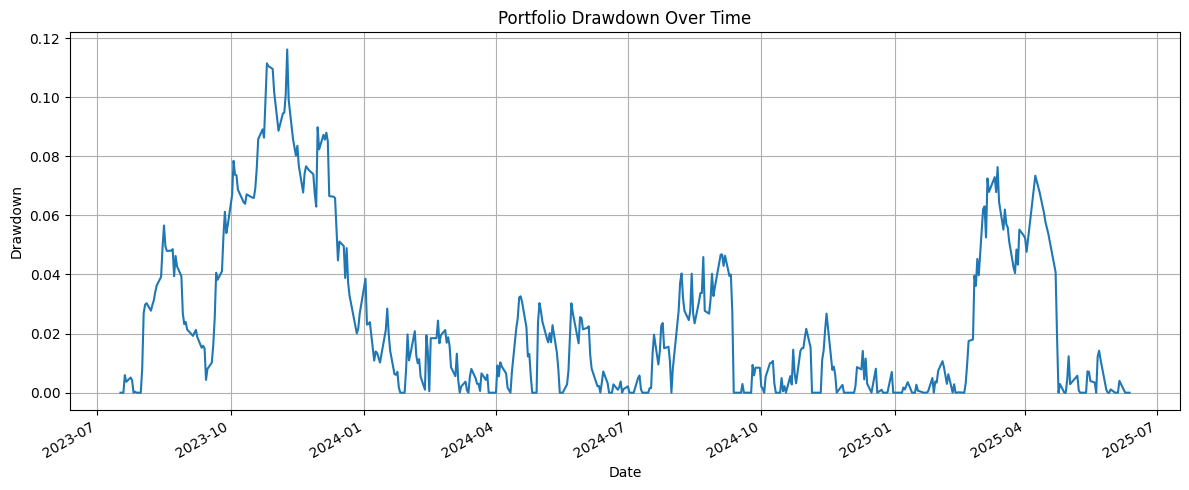

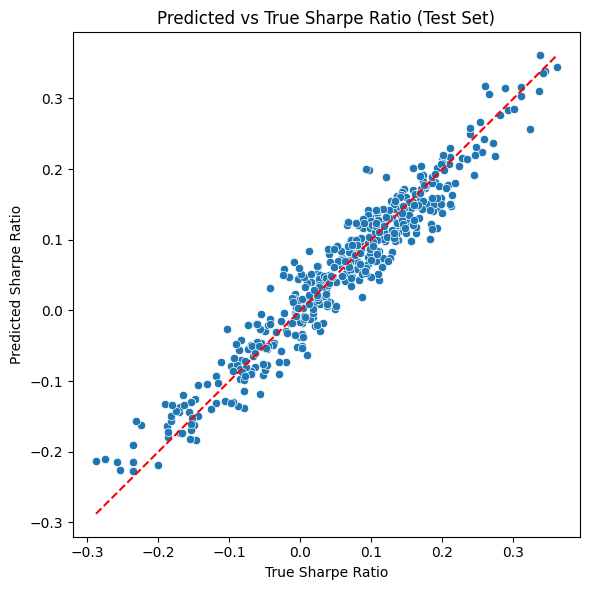

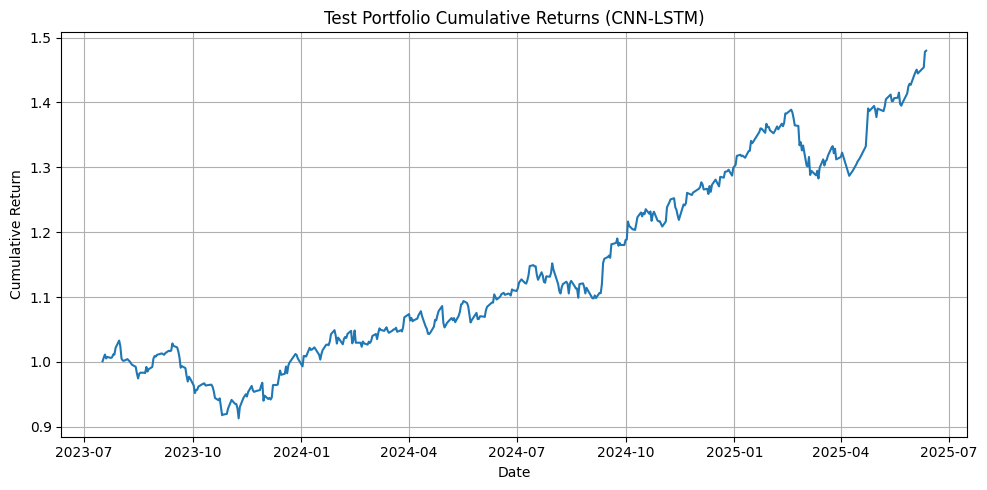

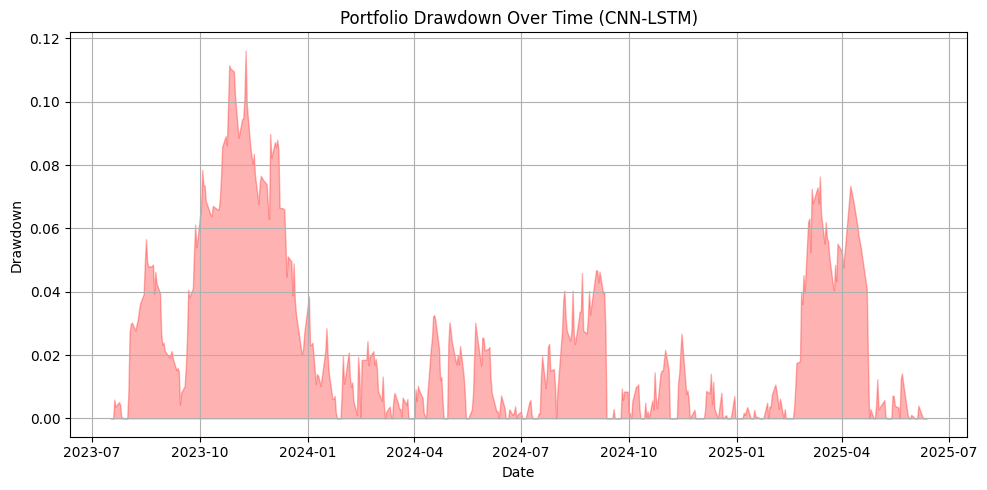

/var/folders/4r/xd1m46rs2r1gx3mmpw3z84pw0000gn/T/ipykernel_45658/798328053.py:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='muted')


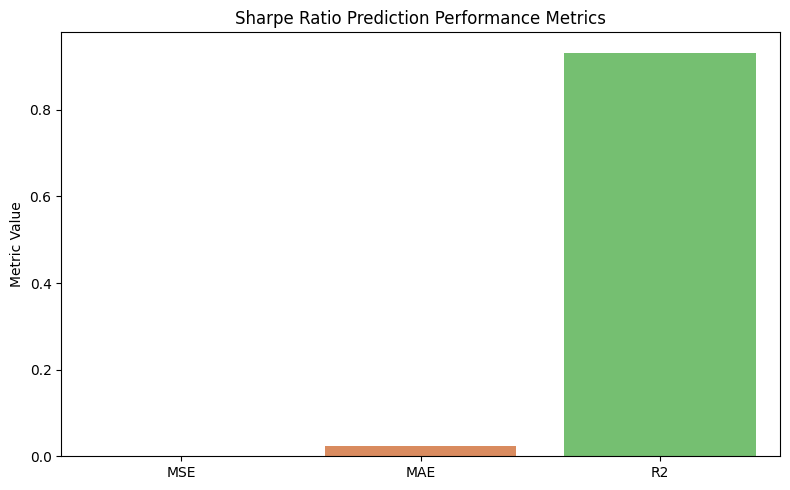

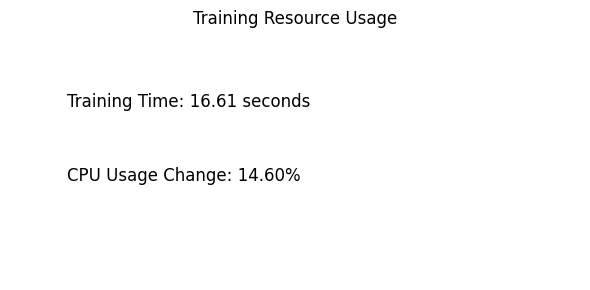

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# assuming the following variables are defined from your CNN-LSTM model and data:
# pred_weights (np.array): predicted portfolio weights, shape (time_steps, n_assets)
# true_sharpe (np.array): true Sharpe ratios for test samples
# pred_sharpe (np.array): predicted Sharpe ratios for test samples
# etf_returns (pd.DataFrame): aligned returns data for test period, shape (time_steps, n_assets)
# assets (list of str): asset tickers or names

# 1. Average Predicted Portfolio Weights (Bar Plot)
avg_weights = pred_weights.mean(axis=0)
plt.figure(figsize=(10,5))
sns.barplot(x=assets, y=avg_weights)
plt.title('Average Predicted Portfolio Weights (CNN-LSTM)')
plt.ylabel('Average Weight')
plt.tight_layout()
plt.show()

# # 1. Pie Chart: Average Portfolio Allocation
# avg_weights = pred_weights.mean(axis=0)
# plt.figure(figsize=(8, 8))
# plt.pie(avg_weights, labels=assets, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
# plt.title('Average Portfolio Allocation Across Test Period')
# plt.tight_layout()
# plt.show()

# 2. Stacked Area Chart: Portfolio Weights Over Time
pred_weights = pd.DataFrame(pred_weights, columns=assets, index=etf_returns.index[-len(pred_weights):])
pred_weights.plot.area(figsize=(14,6), cmap='tab20', alpha=0.85)
plt.title('Portfolio Weights Over Time')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# # 2. Portfolio Weights Over Time (Line Plot)
# plt.figure(figsize=(12,6))
# for asset in assets:
#     plt.plot(pred_weights.index, pred_weights[asset], label=asset)
# plt.title('Portfolio Weights Over Time (CNN-LSTM)')
# plt.xlabel('Date')
# plt.ylabel('Weight')
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# 3. Pie Chart of Average Portfolio Weights
plt.figure(figsize=(8,8))
plt.pie(avg_weights, labels=assets, autopct='%1.1f%%', startangle=140)
plt.title('Average Portfolio Weights Distribution (CNN-LSTM)')
plt.tight_layout()
plt.show()

# 3. Cumulative Returns of Portfolio vs Equal Weight Benchmark
portfolio_returns = np.sum(pred_weights * etf_returns.iloc[-len(pred_weights):].values, axis=1)
cumulative_portfolio = (1 + pd.Series(portfolio_returns, index=weights_df.index)).cumprod()

equal_weight_returns = etf_returns.iloc[-len(pred_weights):].mean(axis=1)
cumulative_equal = (1 + equal_weight_returns).cumprod()

plt.figure(figsize=(14,6))
plt.plot(cumulative_portfolio, label='CNN-LSTM Portfolio')
plt.plot(cumulative_equal, label='Equal Weight Benchmark', linestyle='--')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Rolling Sharpe Ratio (60-day window)
rolling_window = 60
rolling_returns = pd.Series(portfolio_returns, index=weights_df.index).rolling(rolling_window)
rolling_sharpe = rolling_returns.mean() / (rolling_returns.std() + 1e-6) * np.sqrt(252)

plt.figure(figsize=(12,5))
rolling_sharpe.plot()
plt.title(f'Rolling {rolling_window}-Day Sharpe Ratio')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

# # 5. Histogram: Distribution of All Portfolio Weights
# plt.figure(figsize=(10,6))
# sns.histplot(pred_weights.flatten(), bins=50, kde=True, color='skyblue')
# plt.title('Distribution of Portfolio Weights')
# plt.xlabel('Weight')
# plt.ylabel('Frequency')
# plt.tight_layout()
# plt.show()

# 6. Boxplot: Portfolio Weights Per Asset
plt.figure(figsize=(12,6))
sns.boxplot(data=weights_df, palette='Set3')
plt.title('Boxplot of Portfolio Weights per Asset')
plt.ylabel('Weight')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7. Correlation Heatmap: Asset Weights Correlation
plt.figure(figsize=(10,8))
corr_weights = weights_df.corr()
sns.heatmap(corr_weights, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Predicted Asset Weights')
plt.tight_layout()
plt.show()

# 8. Scatter Plot: True vs Predicted Sharpe Ratios
plt.figure(figsize=(8,6))
plt.scatter(true_sharpe, pred_sharpe, alpha=0.5, edgecolors='k')
plt.plot([true_sharpe.min(), true_sharpe.max()], [true_sharpe.min(), true_sharpe.max()], 'r--')
plt.xlabel('True Sharpe Ratio')
plt.ylabel('Predicted Sharpe Ratio')
plt.title('True vs Predicted Sharpe Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Daily Portfolio Turnover Over Time
turnover = np.sum(np.abs(np.diff(pred_weights, axis=0)), axis=1)
plt.figure(figsize=(12,5))
plt.plot(weights_df.index[1:], turnover)
plt.title('Portfolio Daily Turnover')
plt.xlabel('Date')
plt.ylabel('Sum of Absolute Weight Changes')
plt.grid(True)
plt.tight_layout()
plt.show()

# 10. Drawdown Curve
cum_returns = (1 + pd.Series(portfolio_returns, index=weights_df.index)).cumprod()
rolling_max = cum_returns.cummax()
drawdown = (rolling_max - cum_returns) / rolling_max

plt.figure(figsize=(12,5))
drawdown.plot()
plt.title('Portfolio Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Predicted vs True Sharpe Ratio Scatter Plot
plt.figure(figsize=(6,6))
sns.scatterplot(x=true_sharpe, y=pred_sharpe)
min_val = min(min(true_sharpe), min(pred_sharpe))
max_val = max(max(true_sharpe), max(pred_sharpe))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title('Predicted vs True Sharpe Ratio (Test Set)')
plt.xlabel('True Sharpe Ratio')
plt.ylabel('Predicted Sharpe Ratio')
plt.tight_layout()
plt.show()

# 5. Portfolio Cumulative Returns (Test Set)
cum_returns = (1 + pd.Series(portfolio_returns, index=weights_df.index)).cumprod()
plt.figure(figsize=(10,5))
plt.plot(cum_returns.index, cum_returns.values)
plt.title('Test Portfolio Cumulative Returns (CNN-LSTM)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Portfolio Drawdown Plot
peak = cum_returns.cummax()
drawdown = (peak - cum_returns) / peak
plt.figure(figsize=(10,5))
plt.fill_between(drawdown.index, drawdown.values, color='red', alpha=0.3)
plt.title('Portfolio Drawdown Over Time (CNN-LSTM)')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.tight_layout()
plt.show()

# # 7. Heatmap of ETF Allocations Over Time
# plt.figure(figsize=(12,6))
# sns.heatmap(weights_df.T, xticklabels=weights_df.index.strftime('%Y-%m-%d'), yticklabels=assets, cmap='viridis')
# plt.title('Heatmap of ETF Allocation Over Time (CNN-LSTM)')
# plt.xlabel('Date')
# plt.ylabel('ETF')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# 2. Bar Plot of Performance Metrics (MSE, MAE, R²)
metrics = ['MSE', 'MAE', 'R2']
values = [mse_sharpe, mae_sharpe, r2_sharpe]

plt.figure(figsize=(8,5))
sns.barplot(x=metrics, y=values, palette='muted')
plt.title('Sharpe Ratio Prediction Performance Metrics')
plt.ylabel('Metric Value')
plt.tight_layout()
plt.show()

# 3. Display Training Time and CPU Usage as Text Plot
plt.figure(figsize=(6,3))
plt.axis('off')
plt.text(0.1, 0.7, f'Training Time: {train_time:.2f} seconds', fontsize=12)
plt.text(0.1, 0.4, f'CPU Usage Change: {cpu_usage:.2f}%', fontsize=12)
plt.title('Training Resource Usage')
plt.tight_layout()
plt.show()


In [65]:
from graphviz import Digraph

def create_cnn_lstm_pipeline_diagram(filename='cnn_lstm_pipeline', format='png'):
    dot = Digraph(comment='CNN-LSTM (PCA) Pipeline', format=format)

    # Set graph attributes for background and direction (LR for left-to-right)
    dot.attr(rankdir='LR', bgcolor='#F0F8FF', fontname='Helvetica', fontsize='14')

    # Define nodes with sharp font and distinct colors
    node_attrs = {
        'shape': 'box',
        'style': 'filled',
        'fontname': 'Helvetica-Bold',
        'fontsize': '14',
        'color': '#2E86C1',
        'fillcolor': '#D6EAF8',
        'penwidth': '2'
    }

    # Nodes
    dot.node('A', 'Raw Financial Data\n(Daily ETF Prices, Features)', **node_attrs)
    dot.node('B', 'Feature Engineering & Cleaning', **node_attrs)
    dot.node('C', f'PCA\n(Reduce to {7} Components)', **node_attrs)
    dot.node('D', f'Dynamic Target Generation\n(Risk-Parity Weighted Targets)', **node_attrs)
    dot.node('E', 'Sequence Preparation\n(Window Size = 30)', **node_attrs)

    dot.node('F', 'CNN Layer\n(Conv1d 32 filters)', **node_attrs)
    dot.node('G', 'Max Pooling Layer\n(1D Pooling Kernel=2)', **node_attrs)
    dot.node('H', 'LSTM Layer\n(Hidden Size = 64)', **node_attrs)
    dot.node('I', 'Dense Layer & Dropout', **node_attrs)

    # Output heads in ellipse & with distinct colors
    dot.node('J', 'Sharpe Ratio Regression Output', shape='ellipse', fontname='Helvetica-Bold', fontsize='13', color='#117A65', fillcolor='#D1F2EB', style='filled', penwidth='2')
    dot.node('K', 'Portfolio Weights Output\n(Softmax Normalized)', shape='ellipse', fontname='Helvetica-Bold', fontsize='13', color='#196F3D', fillcolor='#ABEBC6', style='filled', penwidth='2')

    # Arrows showing the data flow
    dot.edge('A', 'B', label='Load & Clean Raw Data', fontname='Helvetica')
    dot.edge('B', 'C', label='Apply PCA', fontname='Helvetica')
    dot.edge('C', 'E', label='Dimensionality Reduced Features', fontname='Helvetica')
    dot.edge('D', 'E', label='Generate Dynamic Targets', fontname='Helvetica', style='dotted', color='#85929E')

    dot.edge('E', 'F', label='Sequence Input\n(batch, seq_len=30, features=7)', fontname='Helvetica')
    dot.edge('F', 'G', fontname='Helvetica')
    dot.edge('G', 'H', fontname='Helvetica')
    dot.edge('H', 'I', fontname='Helvetica')
    dot.edge('I', 'J', label='Sharpe Prediction', fontname='Helvetica', color='#117A65')
    dot.edge('I', 'K', label='Portfolio Weights', fontname='Helvetica', color='#196F3D')

    # Render graph
    dot.render(filename, view=True)
    print(f"Diagram saved as {filename}.{format}")

create_cnn_lstm_pipeline_diagram()


Diagram saved as cnn_lstm_pipeline.png


In [67]:
from graphviz import Digraph

g = Digraph('CNN_LSTM_Pipeline', format='png')
g.attr(bgcolor='#FFFFFF')
g.attr(rankdir='LR', splines='polyline', dpi='150')

# Input
g.node('input', 'Input Data\nx1\nx2\n...\nxn', shape='box3d', width='1', height='1.5',
       style='filled', fillcolor='#FFE066', fontname='Arial Black', fontsize='16')

# CNN Group (Convolution + Pooling)
with g.subgraph(name='cluster_cnn') as c:
    c.attr(style='dashed', color='#4890F0', label='CNN Layer', fontname='Arial Black', fontsize='14')
    c.node('conv', 'Convolutional\nLayer', shape='box', style='filled', fillcolor='#F3B0C3', fontname='Arial Black', fontsize='15')
    c.node('pool', 'Max\nPooling', shape='box', style='filled', fillcolor='#A5E0FA', fontname='Arial Black', fontsize='15')
    c.edge('conv', 'pool', color='black', penwidth='2')

# Flatten
g.node('flatten', 'Flatten', shape='parallelogram', style="filled,diagonals", fillcolor='#FBE5D6', fontname="Arial Black", fontsize='15')

# LSTM Layer
g.node('lstm', 'LSTM Layer', shape='rectangle', style='filled,rounded', fillcolor='#B8FAC7', fontname='Arial Black', fontsize='15')

# Dense Layer
g.node('dense', 'Dense Layer', shape='box3d', style='filled', fillcolor='#EDA3D6', fontname='Arial Black', fontsize='15')

# Output
g.node('output', 'Output', shape='box3d', style='filled', fillcolor='#FFE066', fontname='Arial Black', fontsize='16')

# Main flow
g.edge('input', 'conv', color='black', arrowhead='normal', penwidth='3')
g.edge('pool', 'flatten', color='black', arrowhead='normal', penwidth='3')
g.edge('flatten', 'lstm', color='black', arrowhead='normal', penwidth='3')
g.edge('lstm', 'dense', color='black', arrowhead='normal', penwidth='3')
g.edge('dense', 'output', color='black', arrowhead='normal', penwidth='3')

g.attr(labeljust='c')
g.attr(labelloc='b')

# Text flow (under image)
g.node('b1', 'Input Data', shape='plaintext', pos='0, -1!')
g.node('b2', 'CNN Layer', shape='plaintext', pos='1, -1!')
g.node('b3', 'Flatten', shape='plaintext', pos='2, -1!')
g.node('b4', 'LSTM Layer', shape='plaintext', pos='3, -1!')
g.node('b5', 'Dense Layer', shape='plaintext', pos='4, -1!')
g.node('b6', 'Output', shape='plaintext', pos='5, -1!')
g.edge('input', 'b1', arrowhead='none', style='invis')
g.edge('conv', 'b2', arrowhead='none', style='invis')
g.edge('flatten', 'b3', arrowhead='none', style='invis')
g.edge('lstm', 'b4', arrowhead='none', style='invis')
g.edge('dense', 'b5', arrowhead='none', style='invis')
g.edge('output', 'b6', arrowhead='none', style='invis')

g.render('cnn_lstm_architecture', view=True)


'cnn_lstm_architecture.png'

In [69]:
from graphviz import Source

dotcode = """
digraph CNN_LSTM_PCA_Pipeline {
    rankdir=LR;
    bgcolor="#FFFFFF";
    splines=true;
    nodesep=1.2;
    ranksep=1.2;

    node [shape=box, style="filled,rounded", color="#34495E", fontname="Helvetica Bold", fontsize=20, fontcolor="#2C3E50", penwidth=3, fixedsize=false, width=3.5, height=1.5];

    // Input data node
    Data [label=<
        <b>Raw Financial Data</b><br/>
        (Pivoted Features, Dates × Assets)
        >,
        fillcolor="#FFD966",
        color="#CCAA44"
    ];

    // PCA node
    PCA [label=<
        <b>Feature Standardization & PCA</b><br/>
        (Reduce to 7 Components)
        >,
        fillcolor="#99CCFF",
        color="#3366CC"
    ];

    // Dynamic risk-parity target weights
    Targets [label=<
        <b>Dynamic Risk-Parity Target Weights</b><br/>
        (Rolling Window=30)
        >,
        fillcolor="#99FFCC",
        color="#33AA66"
    ];

    // Sequence preparation
    Sequences [label=<
        <b>Sequence Preparation</b><br/>
        (Window Size = 30 Timesteps)
        >,
        fillcolor="#FFBBBB",
        color="#CC4444"
    ];

    // CNN layer
    CNN [label=<
        <b>1D CNN Layer</b><br/>
        Filters=32, Kernel=3, Padding=1
        >,
        fillcolor="#FFD966",
        color="#CC7722"
    ];

    // MaxPooling layer
    MaxPool [label=<
        <b>MaxPooling 1D</b><br/>
        Kernel=2
        >,
        fillcolor="#FFCC77",
        color="#CC9933"
    ];

    // LSTM layer
    LSTM [label=<
        <b>LSTM Layer</b><br/>
        Hidden Size=64
        >,
        fillcolor="#99CC99",
        color="#339933"
    ];

    // Dense + Dropout block
    DenseDropout [label=<
        <b>Dense + Dropout</b><br/>
        Dense=64 Units, Dropout=0.3
        >,
        fillcolor="#CC99CC",
        color="#993399"
    ];

    // Output heads
    SharpeOut [label=<
        <b>Sharpe Ratio Output</b><br/>
        (Regression)
        >,
        shape=ellipse, fillcolor="#FFFF99", color="#CCCC33", fontcolor="#666600", penwidth=3
    ];

    WeightOut [label=<
        <b>Portfolio Weights Output</b><br/>
        (Softmax Normalized)
        >,
        shape=ellipse, fillcolor="#CCFFCC", color="#33AA33", fontcolor="#226622", penwidth=3
    ];

    // Edges showing flow
    Data -> PCA [penwidth=3, color="#6666CC", label="Standardize & PCA"];
    PCA -> Sequences [penwidth=3, color="#3399FF", label="Create Sequences"];
    Targets -> Sequences [penwidth=3, style=dashed, color="#33AA66", label="Supervised Targets"];

    Sequences -> CNN [penwidth=3, color="#FF8800"];
    CNN -> MaxPool [penwidth=3, color="#FFAA33"];
    MaxPool -> LSTM [penwidth=3, color="#88CC44"];
    LSTM -> DenseDropout [penwidth=3, color="#AA66CC"];

    DenseDropout -> SharpeOut [penwidth=3, color="#CCCC33", label="Sharpe Ratio"];
    DenseDropout -> WeightOut [penwidth=3, color="#33AA33", label="Portfolio Weights"];

    {rank=same; CNN; MaxPool;}
}
"""

src = Source(dotcode)
src.render(filename='cnn_lstm_pca_pipeline_new', format='jpeg', cleanup=True)
print("Graph saved as 'cnn_lstm_pca_pipeline_new.jpeg'")


Error: not well-formed (invalid token) in line 2 
... <b>Feature Standardization & PCA ...
in label of node PCA


CalledProcessError: Command '[PosixPath('dot'), '-Kdot', '-Tjpeg', '-O', 'cnn_lstm_pca_pipeline_new']' returned non-zero exit status 1. [stderr: b'Error: not well-formed (invalid token) in line 2 \n... <b>Feature Standardization & PCA ...\nin label of node PCA\n']